# A direct Machine-Learning approach

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import *
from keras.callbacks import *

### Prepocess Data

In [ ]:
cons = pd.read_csv("3_statistics.csv")
cons = cons.drop(["sum", "metadata_id"], axis =1)
cons

,start,state
0,2021-12-12 19:00:00,103.6
1,2021-12-12 20:00:00,103.7
2,2021-12-12 21:00:00,104.0
3,2021-12-12 22:00:00,104.5
4,2021-12-12 23:00:00,104.8
...,...,...
6986,2022-10-05 17:00:00,1221.0
6987,2022-10-05 18:00:00,1221.3
6988,2022-10-05 19:00:00,1221.6
6989,2022-10-05 20:00:00,1221.9


creating a sliding window function

In [ ]:
def sliding_window(train, window = 2, horizon=1):
  tab_x = []
  tab_y = []
  for i in range(0, len(train)-window-horizon):
    x_train = train[i:window+i]
    y_train = train[i+window+horizon-1]
    tab_x.append(x_train)
    tab_y.append(y_train)
  tab_x = np.asarray(tab_x)
  tab_y = np.asarray(tab_y).reshape(-1, )
  return tab_x, tab_y

rescaling the data and creating lag features

In [ ]:
ws = 20
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(cons.state.to_numpy().reshape(-1, 1))
x_train, y_train = sliding_window(scaled_data, window = ws)
val_len = int(len(y_train)*(0.15))
x_train, x_test = x_train[val_len:], x_train[:val_len]
y_train, y_test = y_train[val_len:], y_train[:val_len]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_train.shape

(5925, 20, 1)

### Creating and Training Model

First we approached using an RNN for a single step prediction

In [ ]:
model= Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1],1)))
model.add(SimpleRNN(20))
model.add(Dense(15))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                440       
                                                                 
 dense (Dense)               (None, 15)                315       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',
              optimizer="adam",
              metrics="mse")

In [ ]:
hist = model.fit(x_train, y_train,
          epochs=30,
          batch_size=128,
          validation_data=(x_test, y_test),
         )

Epoch 1/30
47/47 [==============================] - 6s 39ms/step - loss: 0.3892 - mse: 0.3892 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 2/30
47/47 [==============================] - 1s 20ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 3.5455e-04 - val_mse: 3.5455e-04
Epoch 3/30
47/47 [==============================] - 1s 15ms/step - loss: 9.9365e-05 - mse: 9.9365e-05 - val_loss: 9.5171e-05 - val_mse: 9.5171e-05
Epoch 4/30
47/47 [==============================] - 1s 14ms/step - loss: 7.3016e-05 - mse: 7.3016e-05 - val_loss: 1.3669e-04 - val_mse: 1.3669e-04
Epoch 5/30
47/47 [==============================] - 1s 15ms/step - loss: 6.1468e-05 - mse: 6.1468e-05 - val_loss: 2.0668e-04 - val_mse: 2.0668e-04
Epoch 6/30
47/47 [==============================] - 1s 14ms/step - loss: 5.1954e-05 - mse: 5.1954e-05 - val_loss: 2.9288e-04 - val_mse: 2.9288e-04
Epoch 7/30
47/47 [==============================] - 1s 16ms/step - loss: 4.4141e-05 - mse: 4.4141e-05 - val_loss: 3.8384e-04 - val_mse: 3.8384

In [ ]:
pred = model.predict(x=x_test)[0,0]
print(f"prediction: {scalar.inverse_transform(pred.reshape(-1, 1))}")
print(f"Ground Truth: {scalar.inverse_transform(y_test[0][0].reshape(-1, 1))}")

33/33 [==============================] - 0s 3ms/step
prediction: [[148.77718]]
Ground Truth: [[103.6]]


#Multi-step Model

another model to be tested is one using LSTM (Long short term memory) to produce a multi-step prediction

###Data preparation

In [ ]:
#Multi-step Model

def sliding_window(train, window = 2, horizon=1):
  tab_x = []
  for i in range(0, len(train)-window-horizon):
    x_train = train[i:window+i]
    tab_x.append(x_train)
  tab_x = np.asarray(tab_x)
  return tab_x

ws = 24
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(cons.state.to_numpy().reshape(-1, 1))
scaled_data=scaled_data[1: , :]
x_train = sliding_window(scaled_data[:-24], window = ws)
y_train= sliding_window(scaled_data[24:], window=ws)
val_len = int(len(y_train)*(0.15))
x_train, x_test = x_train[val_len:], x_train[:val_len]
y_train, y_test = y_train[val_len:], y_train[:val_len]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_train.shape

(5900, 24, 1)

###Model Creation

In [ ]:
model= Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1],1)))
model.add(LSTM(300))
model.add(Dense(100))
model.add(Dense(24))
model.add(Reshape((1,24,1)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               362400    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 24)                2424      
                                                                 
 reshape (Reshape)           (None, 1, 24, 1)          0         
                                                                 
Total params: 394,924
Trainable params: 394,924
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [ ]:
model.compile(loss='mse',
              optimizer="adam",
              metrics="mse")

In [ ]:
hist = model.fit(x_train, y_train,
          epochs=50,
          batch_size=128,
          validation_data=(x_test, y_test),
         )

Epoch 1/50
47/47 [==============================] - 5s 18ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 2/50
47/47 [==============================] - 0s 7ms/step - loss: 1.1483e-04 - mse: 1.1483e-04 - val_loss: 2.9779e-04 - val_mse: 2.9779e-04
Epoch 3/50
47/47 [==============================] - 0s 7ms/step - loss: 6.3998e-06 - mse: 6.3998e-06 - val_loss: 3.2813e-04 - val_mse: 3.2813e-04
Epoch 4/50
47/47 [==============================] - 0s 7ms/step - loss: 4.4679e-06 - mse: 4.4679e-06 - val_loss: 2.8154e-04 - val_mse: 2.8154e-04
Epoch 5/50
47/47 [==============================] - 0s 7ms/step - loss: 3.7221e-06 - mse: 3.7221e-06 - val_loss: 2.5220e-04 - val_mse: 2.5220e-04
Epoch 6/50
47/47 [==============================] - 0s 8ms/step - loss: 3.2815e-06 - mse: 3.2815e-06 - val_loss: 2.1887e-04 - val_mse: 2.1887e-04
Epoch 7/50
47/47 [==============================] - 0s 7ms/step - loss: 2.9681e-06 - mse: 2.9681e-06 - val_loss: 1.9364e-04 - val_mse: 1.93

#Forcasting

In [ ]:
cons['state'].shape

(6991,)

In [ ]:

def forecast(model, history, n_input):
	# flatten data
	data = history
	#data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat



[[ 103.6]
 [ 103.7]
 [ 104. ]
 ...
 [1221.6]
 [1221.9]
 [1222. ]]
[[2429.0735 ]
 [ 235.9958 ]
 [1551.9962 ]
 [2443.791  ]
 [ 621.581  ]
 [1702.8324 ]
 [2375.5105 ]
 [2591.512  ]
 [2301.5237 ]
 [1985.5312 ]
 [2235.4646 ]
 [ 876.80884]
 [1742.5707 ]
 [1126.2067 ]
 [1410.7196 ]
 [1902.1003 ]
 [1780.0382 ]
 [1106.5005 ]
 [1254.0299 ]
 [2678.4407 ]
 [1875.4875 ]
 [2372.101  ]
 [2463.062  ]
 [2638.6655 ]]


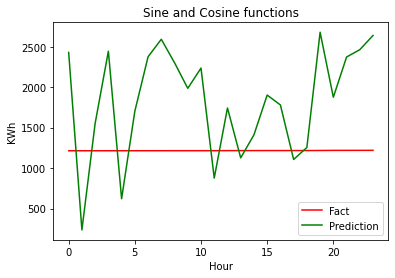

In [ ]:

# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math
new=forecast(model, x_train, 24)

# Using Numpy to create an array X
#X = np.arange(0,  , 1)

# Assign variables to the y axis part of the curve
fact =cons.state.to_numpy().reshape(-1, 1)
print(fact)
new=forecast(model, fact[-48:-24], 24)
new=scalar.inverse_transform(new.reshape(-1, 1))
print(new)
pre=np.array(fact[:-24].reshape(6967,))
post=np.array(new.reshape(24,))
pred = np.concatenate((pre, post), axis=0)
pred=pred.reshape(6991,)

# Plotting both the curves simultaneously
plt.plot( scalar.inverse_transform(y_train.reshape(-1, 1))[-24:], color='r', label='Fact')
plt.plot( new.reshape(24,), color='g', label='Prediction')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Hour")
plt.ylabel("KWh")
plt.title("Sine and Cosine functions")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [ ]:
pip install scalecast --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 680 kB 14.6 MB/s 
     |████████████████████████████████| 216 kB 73.1 MB/s 
     |████████████████████████████████| 133 kB 76.0 MB/s 
  Created wheel for scalecast: filename=SCALECAST-0.15.12-py3-none-any.whl size=110092 sha256=be275a33820d4170ba54069940d6db95eb4b68ef57e72f2924c372b8da413e81
  Stored in directory: /root/.cache/pip/wheels/a4/88/cd/5ad159f36ef3de3396bcce0f0ebf7f0fab3f0b5b0d2e427317
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=832b9a67ac0bd926459b6d05d50a4c31f5fc96978dcd7ab5142294f7160fbadf
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built scalecast eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's 

In [ ]:

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from tensorflow.keras import regularizers

In [ ]:
from pandas.core.frame import Frequency
sns.set(rc={'figure.figsize':(15,8)})
df = pd.read_csv('3_statistics.csv',parse_dates=['start'])
print(df)
df['Datetime'] = pd.to_datetime(df['start'])
dates= df['Datetime']
df = df.set_index('Datetime')

df=df.drop(['sum','metadata_id','start'], axis=1)
df=df.asfreq('h')
df=df.asfreq(freq='H')
dti = pd.date_range("2021-12-12 20:00:00", periods=6991, freq="H")
df=df.diff()
df = df.iloc[1: , :]
df

                   start   state     sum  metadata_id
0    2021-12-12 19:00:00   103.6     0.0            3
1    2021-12-12 20:00:00   103.7     0.1            3
2    2021-12-12 21:00:00   104.0     0.4            3
3    2021-12-12 22:00:00   104.5     0.9            3
4    2021-12-12 23:00:00   104.8     1.2            3
...                  ...     ...     ...          ...
6986 2022-10-05 17:00:00  1221.0  1099.5            3
6987 2022-10-05 18:00:00  1221.3  1099.8            3
6988 2022-10-05 19:00:00  1221.6  1100.1            3
6989 2022-10-05 20:00:00  1221.9  1100.4            3
6990 2022-10-05 21:00:00  1222.0  1100.5            3

[6991 rows x 4 columns]


,state
Datetime,
2021-12-12 20:00:00,0.1
2021-12-12 21:00:00,0.3
2021-12-12 22:00:00,0.5
2021-12-12 23:00:00,0.3
2021-12-13 00:00:00,0.0
...,...
2022-10-05 17:00:00,0.4
2022-10-05 18:00:00,0.3
2022-10-05 19:00:00,0.3


In [ ]:
f = Forecaster(y=df['state'],current_dates=dti)
f

Forecaster(
    DateStartActuals=2021-12-13T15:00:00.000000000
    DateEndActuals=2022-09-30T02:00:00.000000000
    Freq=H
    N_actuals=6972
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

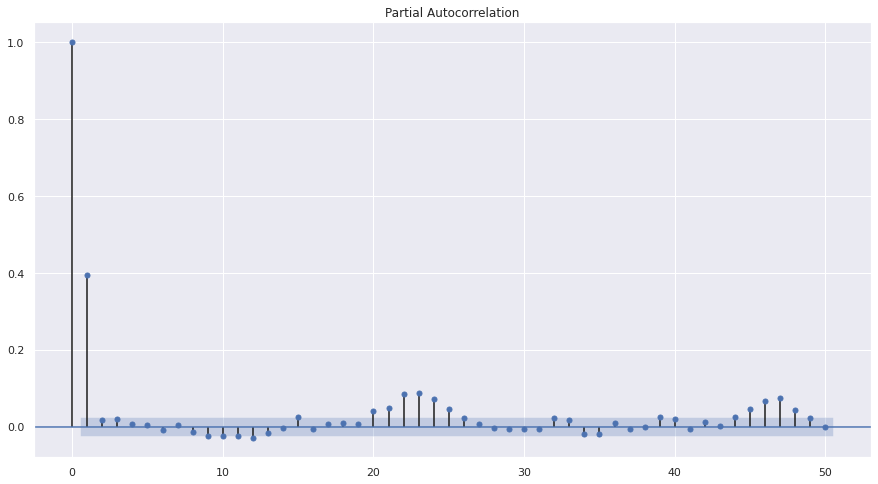

In [ ]:
f.plot_pacf(lags=50)
plt.show()

In [ ]:
f

Forecaster(
    DateStartActuals=2021-12-13T15:00:00.000000000
    DateEndActuals=2022-09-30T02:00:00.000000000
    Freq=H
    N_actuals=6972
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

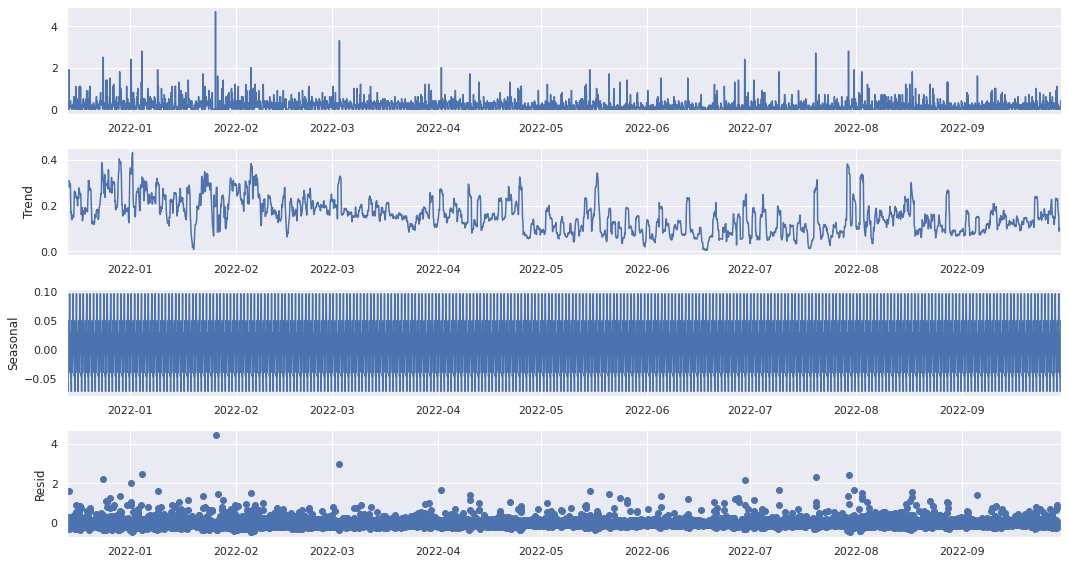

In [ ]:
f.seasonal_decompose().plot()
plt.show()

In [ ]:
df
#df=df.dropna()
df

,state
Datetime,
2021-12-12 20:00:00,0.1
2021-12-12 21:00:00,0.3
2021-12-12 22:00:00,0.5
2021-12-12 23:00:00,0.3
2021-12-13 00:00:00,0.0
...,...
2022-10-05 17:00:00,0.4
2022-10-05 18:00:00,0.3
2022-10-05 19:00:00,0.3


In [ ]:
#Multi-step Model

def sliding_window(train, window = 2, horizon=1):
  tab_x = []
  for i in range(0, len(train)-window-horizon):
    x_train = train[i:window+i]
    tab_x.append(x_train)
  tab_x = np.asarray(tab_x)
  return tab_x

ws = 24
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaled_data = scalar.fit_transform(df.state.to_numpy().reshape(-1, 1))
scaled_data=scaled_data[1: , :]
scaled_data = scaled_data[~np.isnan(scaled_data)]
x_train = sliding_window(scaled_data[:-24], window = 336)
y_train= sliding_window(scaled_data[24:], window=ws, horizon=312)
y_train=y_train[1:]
val_len = int(len(y_train)*(0.15))
x_train, x_test = x_train[val_len:], x_train[:val_len]
y_train, y_test = y_train[val_len:], y_train[:val_len]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#x_train=x_train[:-1]
print(y_train.shape)
#y_train = np.reshape(y_train, ( 24,1))
#y_test = np.reshape(y_test, (1, 24, 1))
print(x_train.shape,y_train.shape)

(5619, 24)
(5619, 336, 1) (5619, 24)


In [ ]:
model= Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1],1)))
model.add(LSTM(300,bias_regularizer=regularizers.L2(0.05),dropout=0.1,))
model.add(Dense(300, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Reshape((1,24)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 300)               362400    
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                                 
 dense_5 (Dense)             (None, 24)                7224      
                                                                 
 reshape_1 (Reshape)         (None, 1, 24)             0         
                                                                 
Total params: 459,924
Trainable params: 459,924
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mae',
              optimizer="adam",
              metrics="mse")

In [ ]:
hist = model.fit(x_train, y_train,
          epochs=50,
          batch_size=128,
          validation_data=(x_test, y_test),
         )

Epoch 1/50
44/44 [==============================] - 5s 79ms/step - loss: 14.3966 - mse: 0.0028 - val_loss: 13.7565 - val_mse: 0.0051
Epoch 2/50
44/44 [==============================] - 3s 67ms/step - loss: 13.1502 - mse: 0.0026 - val_loss: 12.5523 - val_mse: 0.0050
Epoch 3/50
44/44 [==============================] - 3s 67ms/step - loss: 11.9860 - mse: 0.0026 - val_loss: 11.4296 - val_mse: 0.0051
Epoch 4/50
44/44 [==============================] - 3s 69ms/step - loss: 10.9013 - mse: 0.0026 - val_loss: 10.3843 - val_mse: 0.0050
Epoch 5/50
44/44 [==============================] - 3s 67ms/step - loss: 9.8926 - mse: 0.0026 - val_loss: 9.4134 - val_mse: 0.0050
Epoch 6/50
44/44 [==============================] - 3s 69ms/step - loss: 8.9564 - mse: 0.0026 - val_loss: 8.5131 - val_mse: 0.0050
Epoch 7/50
44/44 [==============================] - 3s 66ms/step - loss: 8.0894 - mse: 0.0026 - val_loss: 7.6803 - val_mse: 0.0050
Epoch 8/50
44/44 [==============================] - 3s 69ms/step - loss: 7.

[[ 103.6]
 [ 103.7]
 [ 104. ]
 ...
 [1221.6]
 [1221.9]
 [1222. ]]
[[0.        ]
 [0.        ]
 [1.9553875 ]
 [0.95328826]
 [0.        ]
 [0.        ]
 [2.8578804 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.07524458]
 [0.9663947 ]
 [0.03367174]
 [1.7694049 ]
 [2.1115472 ]
 [1.3630253 ]
 [0.7750969 ]
 [2.2886863 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.7106467 ]
 [0.        ]
 [3.7946706 ]]
the fact is [[0.        ]
 [0.        ]
 [0.08147448]
 [0.03972035]
 [0.        ]
 [0.        ]
 [0.11907835]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00313519]
 [0.04026645]
 [0.00140299]
 [0.0737252 ]
 [0.08798113]
 [0.05679272]
 [0.0322957 ]
 [0.09536193]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.07127695]
 [0.        ]
 [0.15811127]] and the prediction is [4.31666667 4.32083333 4.33333333 ... 0.07127695 0.         0.15811127]


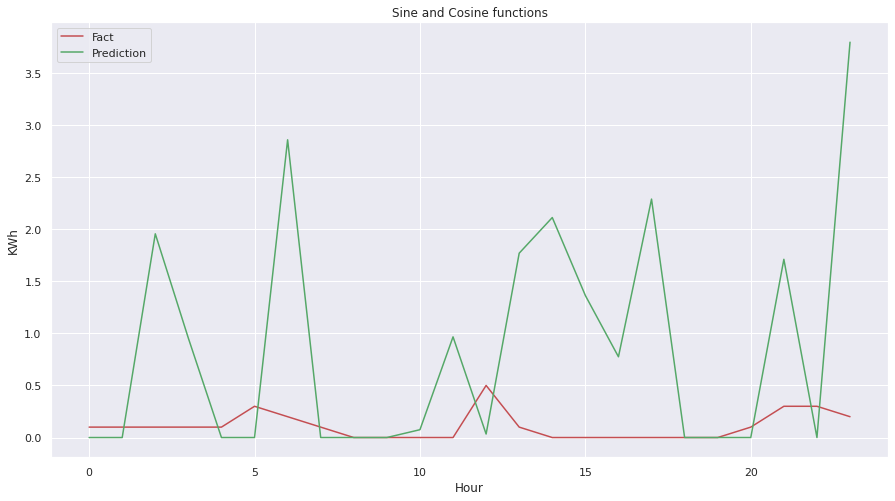

In [ ]:

# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math
new=forecast(model, x_train, 336)

# Using Numpy to create an array X
#X = np.arange(0,  , 1)

# Assign variables to the y axis part of the curve
fact =cons.state.to_numpy().reshape(-1, 1)
print(fact)
new=forecast(model, fact[-48:-24], 24)
new=scalar.inverse_transform(new.reshape(-1, 1))
print(new)


pre=np.array(fact[:-24].reshape(6967,))
post=np.array(new.reshape(24,))
pred = np.concatenate((pre, post), axis=0)
pred=pred.reshape(6991,)

print(f'the fact is {new/24} and the prediction is {pred/24}')

# Plotting both the curves simultaneously
plt.plot( scalar.inverse_transform(y_train.reshape(-1, 1))[-24:], color='r', label='Fact')
plt.plot( new.reshape(24,), color='g', label='Prediction')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Hour")
plt.ylabel("KWh")
plt.title("Sine and Cosine functions")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()